In [1]:
pip install pyserial firebase-admin pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import firebase_admin
from firebase_admin import credentials, db as rtdb

SERVICE_KEY_PATH = r"C:\Users\DELL\Downloads\p---sit225-firebase-adminsdk-fbsvc-3e82ed20b0.json"
DATABASE_URL = "https://p---sit225-default-rtdb.firebaseio.com/"
DEVICE_ID = "nano33iot-01"

try:
    rt_app = firebase_admin.get_app("rt")
except ValueError:
    cred = credentials.Certificate(SERVICE_KEY_PATH)
    rt_app = firebase_admin.initialize_app(cred, {"databaseURL": DATABASE_URL}, name="rt")

gyro_ref = rtdb.reference(f"/gyro_readings/{DEVICE_ID}", app=rt_app)
print("RTDB ready:", DATABASE_URL)


RTDB ready: https://p---sit225-default-rtdb.firebaseio.com/


In [3]:
import serial, json, time
from datetime import datetime, timezone

PORT = "COM5"
BAUD = 115200

def iso_utc():
    return datetime.now(timezone.utc).replace(microsecond=0).isoformat().replace("+00:00","Z")

ser = serial.Serial(PORT, BAUD, timeout=2)
print("Serial open on", PORT)

count = 0
start = time.time()
try:
    first = ser.readline().decode(errors="ignore").strip()
    if "gx_dps" not in first:
        pass

    while True:
        line = ser.readline().decode(errors="ignore").strip()
        if not line:
            continue
        try:
            ts_ms_s, gx_s, gy_s, gz_s = line.split(",")
            ts_ms = int(ts_ms_s)
            gx = float(gx_s); gy = float(gy_s); gz = float(gz_s)
        except Exception:
            continue

        payload = {
            "sensor_name": "gyro",
            "device_id": DEVICE_ID,
            "timestamp": iso_utc(),
            "ts_device_ms": ts_ms,
            "data": {"gx_dps": gx, "gy_dps": gy, "gz_dps": gz}
        }
        gyro_ref.push(payload)
        count += 1

        if count % 250 == 0:
            print(f"Pushed {count} samples… {(time.time()-start):.1f}s")

except KeyboardInterrupt:
    print("Stopped by user")
finally:
    ser.close()
    print("Closed serial")


Serial open on COM5
Pushed 250 samples… 60.6s
Pushed 500 samples… 119.1s
Pushed 750 samples… 177.6s
Pushed 1000 samples… 238.6s
Pushed 1250 samples… 300.8s
Pushed 1500 samples… 361.2s
Pushed 1750 samples… 421.1s
Pushed 2000 samples… 483.3s
Pushed 2250 samples… 547.4s
Pushed 2500 samples… 611.6s
Pushed 2750 samples… 678.0s
Pushed 3000 samples… 743.9s
Pushed 3250 samples… 809.3s
Pushed 3500 samples… 867.7s
Pushed 3750 samples… 925.0s
Pushed 4000 samples… 981.8s
Pushed 4250 samples… 1049.0s
Pushed 4500 samples… 1116.4s
Pushed 4750 samples… 1182.6s
Pushed 5000 samples… 1250.4s
Pushed 5250 samples… 1309.6s
Pushed 5500 samples… 1371.4s
Pushed 5750 samples… 1432.4s
Pushed 6000 samples… 1491.4s
Pushed 6250 samples… 1559.7s
Pushed 6500 samples… 1628.0s
Pushed 6750 samples… 1695.9s
Pushed 7000 samples… 1764.4s
Pushed 7250 samples… 1833.3s
Pushed 7500 samples… 1901.1s
Pushed 7750 samples… 1968.3s
Pushed 8000 samples… 2036.0s
Pushed 8250 samples… 2104.1s
Pushed 8500 samples… 2169.9s
Pushed 8750 sa

In [9]:
import pandas as pd

snap = gyro_ref.get() or {}
records = []
for key, doc in snap.items():
    records.append({
        "id": key,
        "device_id": doc.get("device_id"),
        "timestamp": doc.get("timestamp"),
        "ts_device_ms": doc.get("ts_device_ms"),
        "gx_dps": doc.get("data",{}).get("gx_dps"),
        "gy_dps": doc.get("data",{}).get("gy_dps"),
        "gz_dps": doc.get("data",{}).get("gz_dps"),
    })

df = pd.DataFrame.from_records(records)
for c in ["gx_dps","gy_dps","gz_dps"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["ts_device_ms"] = pd.to_numeric(df["ts_device_ms"], errors="coerce")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

df = df.sort_values("timestamp").reset_index(drop=True)
csv_path = "gyro_readings.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path, "rows:", len(df))
df.head()


Saved: gyro_readings.csv rows: 11579


,id,device_id,timestamp,ts_device_ms,gx_dps,gy_dps,gz_dps
0,-OYt_BC33MNY4_PR9f7p,nano33iot-01,2025-08-30 06:05:31+00:00,333213,-0.061035,-0.549316,0.061035
1,-OYt_BFq6n_xwbX0yR_R,nano33iot-01,2025-08-30 06:05:32+00:00,333233,0.000000,-0.549316,0.122070
2,-OYt_BJYXmYt3RrPV6HY,nano33iot-01,2025-08-30 06:05:32+00:00,333253,0.000000,-0.549316,0.061035
3,-OYt_BNHKbxd0XU194Yp,nano33iot-01,2025-08-30 06:05:32+00:00,333273,-0.061035,-0.549316,0.122070
4,-OYt_BQzDBeK6zaGfGHN,nano33iot-01,2025-08-30 06:05:33+00:00,333293,-0.061035,-0.488281,0.061035


In [11]:
df_clean = df.dropna(subset=["gx_dps","gy_dps","gz_dps","timestamp"])

mask = (df_clean[["gx_dps","gy_dps","gz_dps"]].abs() <= 2000).all(axis=1)
df_clean = df_clean[mask].copy()

df_clean.to_csv("gyro_readings_clean.csv", index=False)
print("Clean rows:", len(df_clean))


Clean rows: 11579


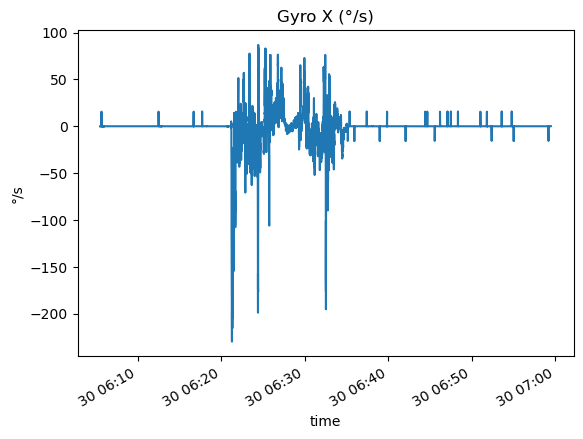

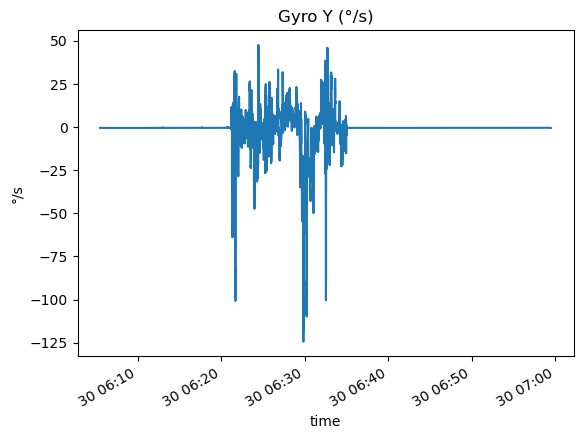

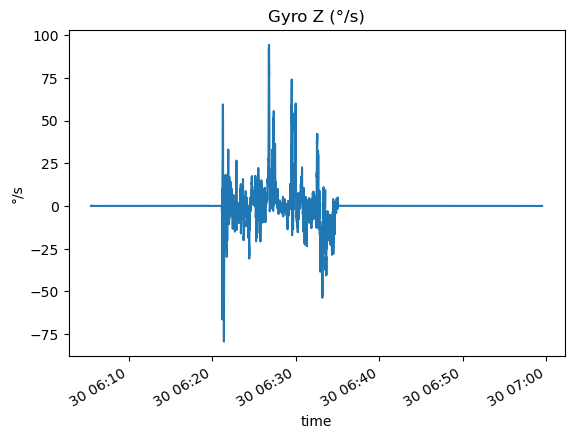

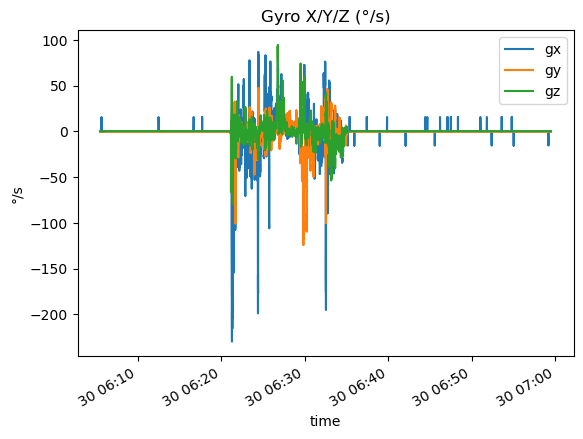

In [13]:
import matplotlib.pyplot as plt

d = df_clean.copy().set_index("timestamp").sort_index()

plt.figure(); d["gx_dps"].plot(title="Gyro X (°/s)"); plt.xlabel("time"); plt.ylabel("°/s")
plt.figure(); d["gy_dps"].plot(title="Gyro Y (°/s)"); plt.xlabel("time"); plt.ylabel("°/s")
plt.figure(); d["gz_dps"].plot(title="Gyro Z (°/s)"); plt.xlabel("time"); plt.ylabel("°/s")

plt.figure()
d["gx_dps"].plot()
d["gy_dps"].plot()
d["gz_dps"].plot()
plt.title("Gyro X/Y/Z (°/s)")
plt.xlabel("time"); plt.ylabel("°/s"); plt.legend(["gx","gy","gz"])
plt.show()
